In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
METRICS = ['Validation/total_unscaled_loss', 'Validation/unscaled_dyn_loss', 'Validation/value_prefix_loss', 'Validation/recon_loss', 'trainer/global_step']

In [3]:
api = wandb.Api()

In [18]:
if not os.path.exists('./perc_dropout_experiments/losses.npz'):
    os.makedirs('./perc_dropout_experiments', exist_ok=True)
    runs = api.runs("TomFrederik/MT-ToyTask-Ours", filters = {"group": "dense_perc_dropout"})
    losses = {}
    for run in tqdm(runs):
        path = os.path.join('./per_dropout_experiments', run.id)
        setting = run.id.split("_")[1]
        # if setting not in ['0', '2', '4', '6']:
        #     continue
        
        if setting not in losses:
            losses[setting] = []
        history = run.scan_history(keys=METRICS)
        loss = {metric: [row[metric] for row in history] for metric in METRICS}
        losses[setting].append(loss)

    for key, value in losses.items():
        losses[key] = {metric: np.array([run[metric] for run in losses[key]]) for metric in METRICS}
    np.savez_compressed('./perc_dropout_experiments/losses.npz', **losses)
else:
    losses = np.load('./perc_dropout_experiments/losses.npz', allow_pickle=True)

87it [13:30,  9.31s/it]                        
/tmp/ipykernel_13032/3732123230.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  losses[key] = {metric: np.array([run[metric] for run in losses[key]]) for metric in METRICS}


In [20]:
print(list(losses.keys()))
print(losses['20'])

['16', '15', '14', '13', '12', '11', '10', '1', '9', '0', '18', '8', '7', '6', '5', '4', '3', '20', '2', '19', '17']
{'Validation/total_unscaled_loss': array([[3.09652925, 2.9328208 , 2.9111495 ],
       [1.53598511, 1.93545651, 3.22407556],
       [1.53598511, 1.93545651, 3.22407556],
       [2.59778476, 2.61525249, 2.56885004]]), 'Validation/unscaled_dyn_loss': array([[2.49387693, 2.34910941, 2.3384707 ],
       [0.02965687, 0.60736382, 2.08239698],
       [0.02965687, 0.60736382, 2.08239698],
       [1.70256698, 1.73132062, 1.75369334]]), 'Validation/value_prefix_loss': array([[0.01061315, 0.0084517 , 0.00426335],
       [0.23493978, 0.08304019, 0.08449121],
       [0.23493978, 0.08304019, 0.08449121],
       [0.05234629, 0.05185476, 0.03377716]]), 'Validation/recon_loss': array([[0.59203911, 0.57525986, 0.56841552],
       [1.27138841, 1.24505258, 1.0571878 ],
       [1.27138841, 1.24505258, 1.0571878 ],
       [0.84287208, 0.83207726, 0.78137994]]), 'trainer/global_step': array([[

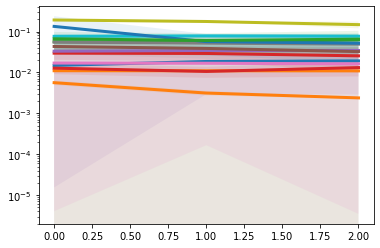

In [25]:
plt.figure()
for key, val in losses.items():
    # if key not in ['0', '2', '4', '6']:
    # if key not in ['20']:
    #     continue
    value = val['Validation/value_prefix_loss']
    if value.dtype != np.float64: # is nan
        continue
    mean = value.mean(axis=0)
    std = value.std(axis=0)
    plt.plot(mean, linewidth=3)
    plt.fill_between(np.arange(3), mean-std, mean+std, alpha=0.1)
plt.yscale('log')
plt.show()

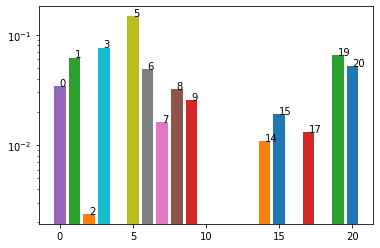

In [28]:
plt.figure()
for key, val in losses.items():
    # if key not in ['0', '2', '4', '6']:
    # if key not in ['20']:
    #     continue
    value = val['Validation/value_prefix_loss']
    if value.dtype != np.float64: # is nan
        continue
    mean = value.mean(axis=0)
    std = value.std(axis=0)
    plt.bar(int(key), mean[-1])
    plt.text(int(key), mean[-1], f'{key}')
    # plt.fill_between(np.arange(3), mean-std, mean+std, alpha=0.1)
plt.yscale('log')
plt.show()

In [30]:
# create a mapping from key to dropout for fixed test-only-dropout and percentage
perc_05_no = {
    2: 0.1,
    4: 0.2,
    6: 0.5,
}
perc_05_yes = {
    0: 0,
    1: 0.1,
    3: 0.2,
    5: 0.5,
}
perc_075_no = {
    9: 0.1,
    11: 0.2,
    13: 0.5,
}
perc_075_yes = {
    7: 0,
    8: 0.1,
    10: 0.2,
    12: 0.5,
}
perc_1_no = {
    16: 0.1,
    18: 0.2,
    20: 0.5,
}
perc_1_yes = {
    14: 0,
    15: 0.1,
    17: 0.2,
    19: 0.5,
}

settings = {
    (0.5, 'no'): perc_05_no,
    (0.5, 'yes'): perc_05_yes,
    (0.75, 'no'): perc_075_no,
    (0.75, 'yes'): perc_075_yes,
    (1, 'no'): perc_1_no,
    (1, 'yes'): perc_1_yes,
}


In [43]:
results_by_setting = {}
for setting, keys in settings.items():
    results_by_setting[setting] = {'mean': [], 'std': []}
    for key in keys.keys():
        value = losses[str(key)]['Validation/value_prefix_loss']
        if value.dtype != np.float64: # is nan
            continue    
        results_by_setting[setting]['mean'].append(value.mean(axis=0)[-1])
        results_by_setting[setting]['std'].append(value.std(axis=0)[-1])
    results_by_setting[setting]['mean'] = np.array(results_by_setting[setting]['mean'])
    results_by_setting[setting]['std'] = np.array(results_by_setting[setting]['std'])
print(results_by_setting)

{(0.5, 'no'): {'mean': array([0.00238433, 0.04905825]), 'std': array([9.93458088e-05, 3.26154344e-02])}, (0.5, 'yes'): {'mean': array([0.0343895 , 0.06211694, 0.07660733, 0.14716471]), 'std': array([0.03147742, 0.02615187, 0.01326479, 0.02782528])}, (0.75, 'no'): {'mean': array([0.02542787]), 'std': array([0.01546438])}, (0.75, 'yes'): {'mean': array([0.01618098, 0.03227174]), 'std': array([0.0161775 , 0.00952215])}, (1, 'no'): {'mean': array([0.05175573]), 'std': array([0.03435833])}, (1, 'yes'): {'mean': array([0.0108986 , 0.01913995, 0.01312907, 0.06506465]), 'std': array([0.0243627 , 0.03363815, 0.00513815, 0.03883323])}}


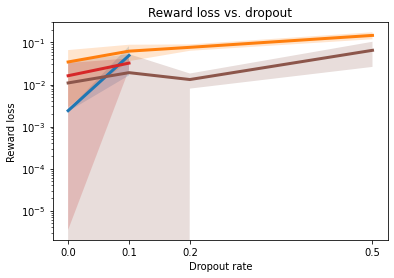

In [47]:
plt.figure()
for setting, values in results_by_setting.items():
    plt.plot([0, 0.1, 0.2, 0.5][:len(values['mean'])], values['mean'], linewidth=3, label=f"{setting}")
    plt.fill_between([0, 0.1, 0.2, 0.5][:len(values['mean'])], values['mean']-values['std'], values['mean']+values['std'], alpha=0.2)
plt.xticks([0, 0.1, 0.2, 0.5])
plt.yscale('log')
# plt.legend()
plt.title('Reward loss vs. dropout')
plt.xlabel("Dropout rate")
plt.ylabel("Reward loss")
plt.show()